In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib
import random as rand
from matplotlib import pyplot as plt
from itertools import product
import itertools
import time
import re
import csv
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox
import statsmodels.api as sm
import tqdm

%matplotlib inline

In [2]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [17., 8.]

## Import CSV data
With DDPG agent

In [3]:
data_ddpg = pd.read_csv('data/params_search/params_7_ddpg.csv')
data_ddpg.head(5)

,Id,price,volume,bid_price,ask_price,bid_volume,ask_volume,MM1,LC1,MT1,MRT1,NT1,DDPG1
0,0,100.82,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,1,100.78,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100.74,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100.69,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100.65,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0


And without DDPG agent

In [4]:
data_default = pd.read_csv('data/params_search/params_5.csv')
data_default.head(5)

,Id,price,volume,bid_price,ask_price,bid_volume,ask_volume,MM1,LC1,MT1,MRT1,NT1,DDPG1
0,0,100.82,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0
1,1,100.78,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0
2,2,100.74,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0
3,3,100.69,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0
4,4,100.65,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0


------
Returns data

In [5]:
data_ddpg['returns'] = data_ddpg["price"].pct_change()
data_default['returns'] = data_default["price"].pct_change()

### DDPG price and returns

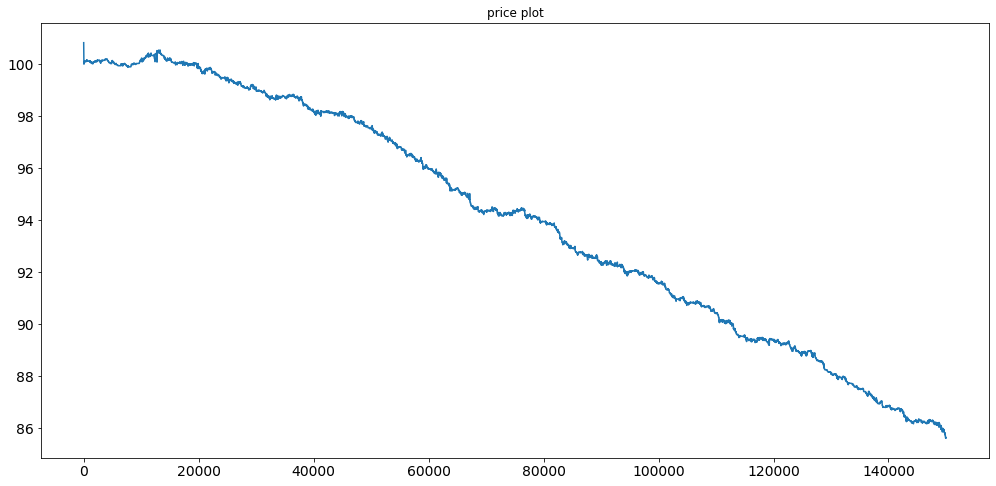

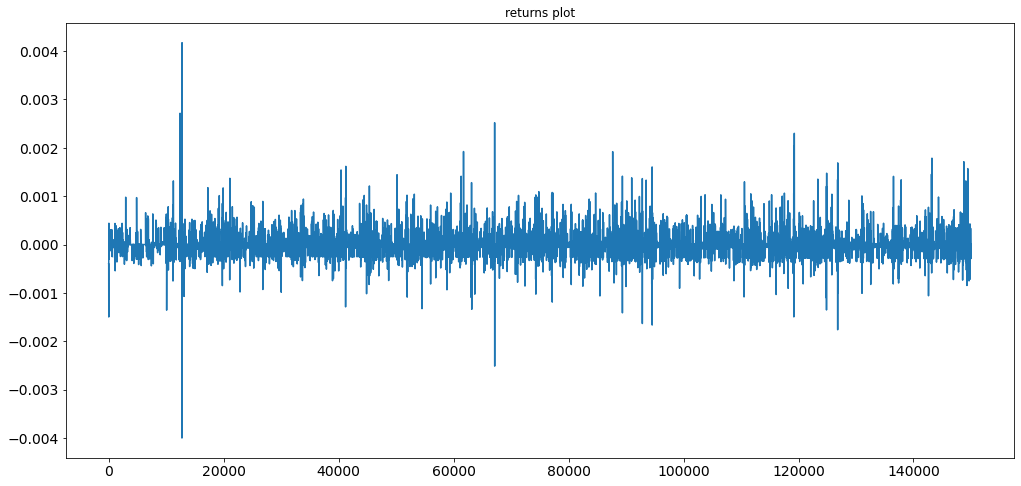

In [6]:
plt.plot(data_ddpg['price'])
plt.title('price plot')
plt.show()

plt.plot(data_ddpg['returns'])
plt.title('returns plot')
plt.show()

### Default price and returns

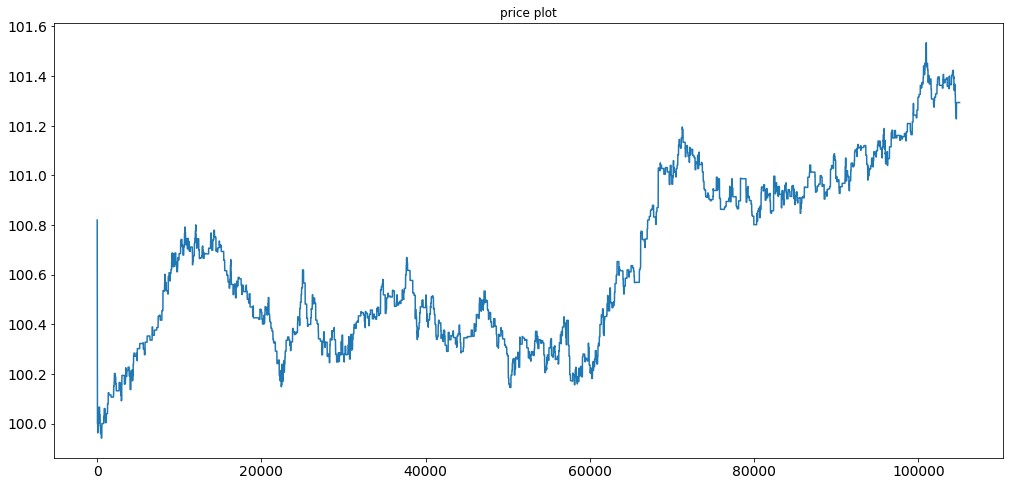

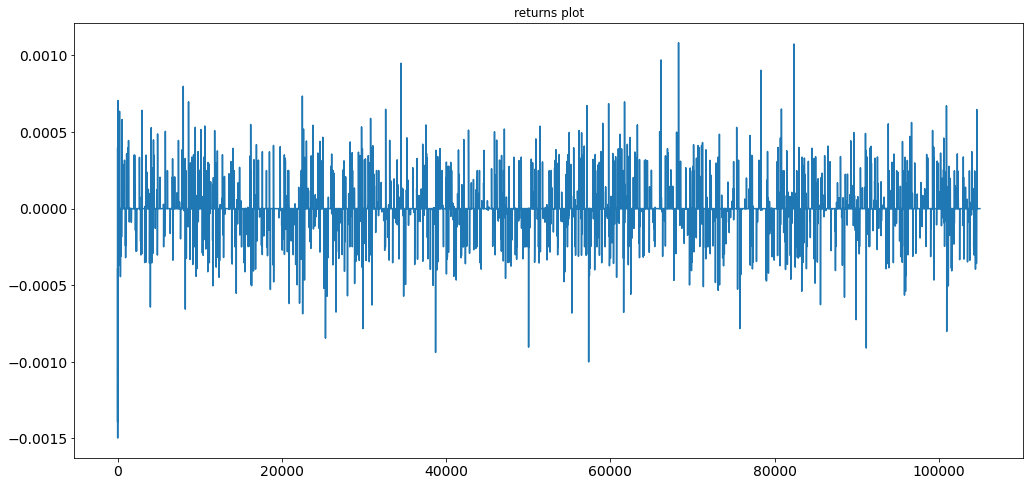

In [7]:
plt.plot(data_default['price'])
plt.title('price plot')
plt.show()

plt.plot(data_default['returns'])
plt.title('returns plot')
plt.show()

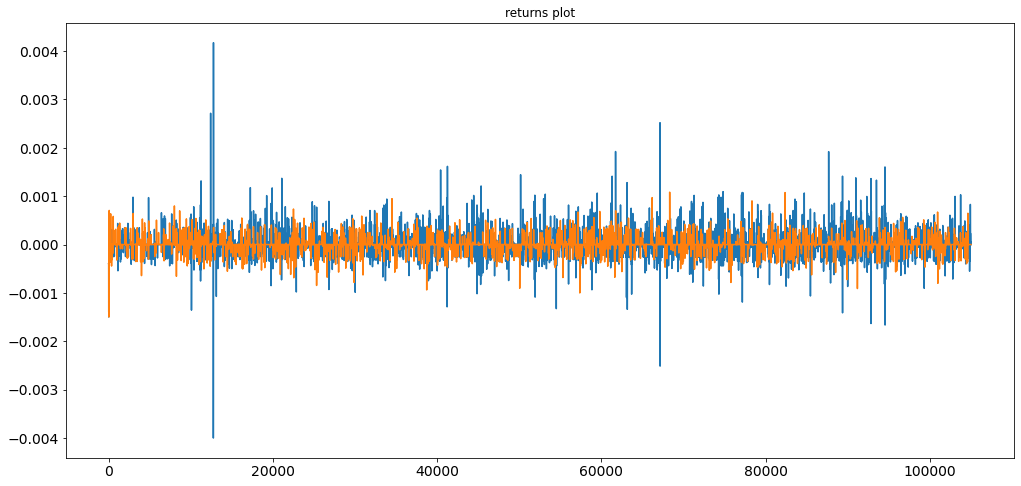

In [8]:
plt.plot(data_ddpg['returns'][:105000])
plt.title('returns plot')
plt.plot(data_default['returns'])
plt.title('returns plot')
plt.show()

In [9]:
np.mean(data_ddpg['returns'])

-1.0870929667990261e-06

In [10]:
np.mean(data_default['returns'])

4.514851177857874e-08

-------
## Fat tailed distribution comparing  

Let use kurtosis value (4'th moment) to calculate value of the tail of returns

In [11]:
kurt_list_ddpg = [data_ddpg["price"].pct_change(k).kurt() for k in range(3000)]
kurt_list_default = [data_default["price"].pct_change(k).kurt() for k in range(3000)]

In [12]:
data_ddpg["price"].pct_change().kurt()

448.7338511592076

In [13]:
data_default["price"].pct_change().kurt()

301.196113506951

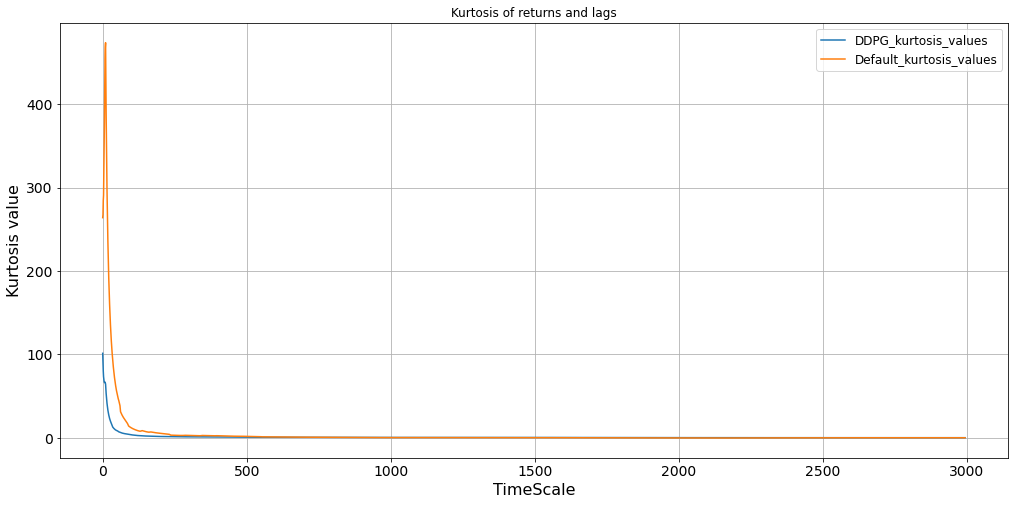

In [14]:
plt.plot(kurt_list_ddpg[5:], label = 'DDPG_kurtosis_values')
plt.plot(kurt_list_default[5:], label = 'Default_kurtosis_values')
plt.title('Kurtosis of returns and lags')
plt.xlabel('TimeScale')
plt.ylabel('Kurtosis value')
plt.grid(True)
plt.legend()
plt.show()

Along the abscissa axis, the kurtosis value readings are plotted depending on the degree of differentiation of the series

------
## Volatility clustering comparing  

We can use autocorrealtion of squared returns function as measure of volatility clustering (ARCH effect)  

Also we can use returns in other degrees to calculate other data (GARCH effect).

Default plot

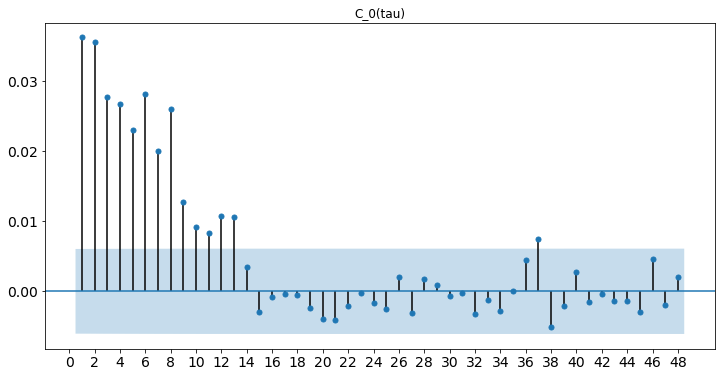

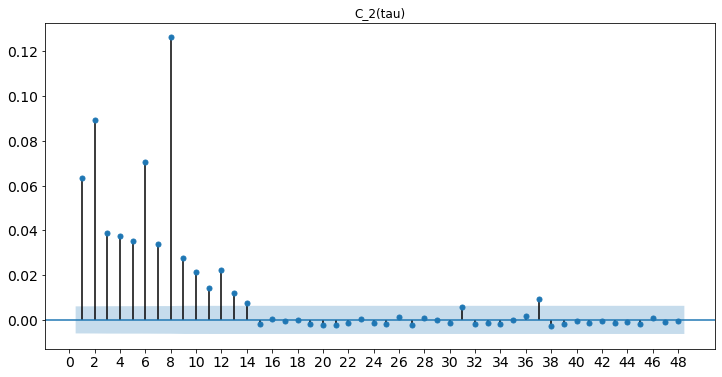

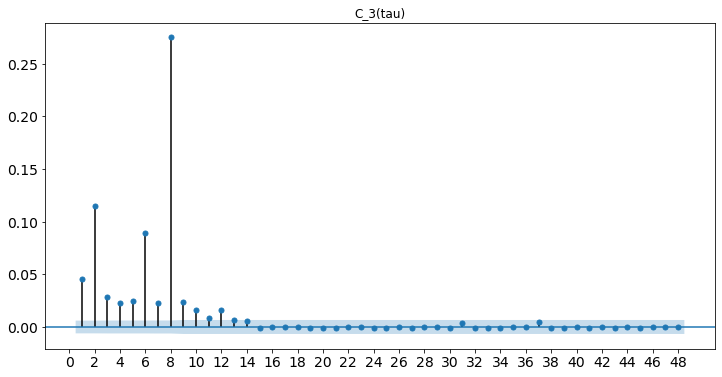

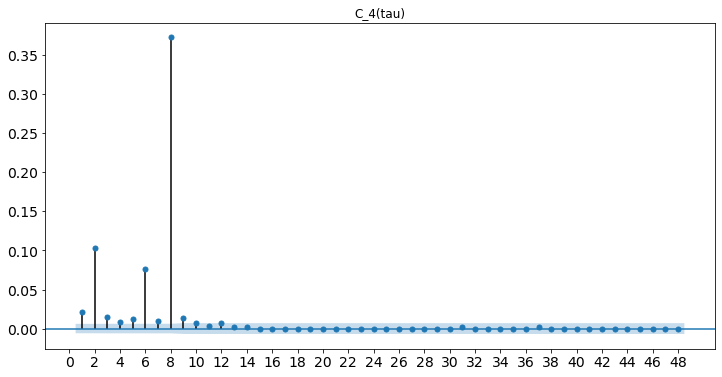

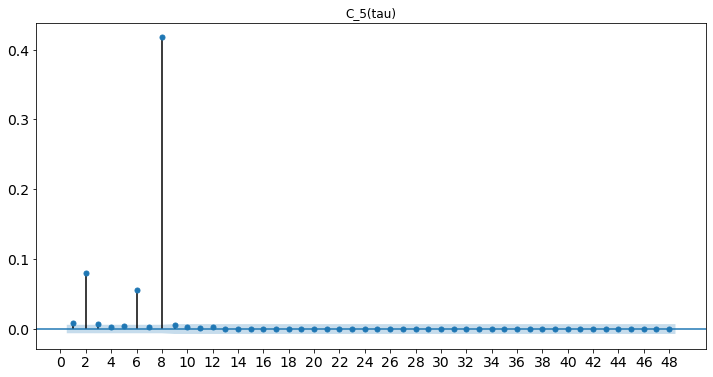

In [15]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(np.log(1+abs(data_default['returns'].fillna(0))), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_0(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_default['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_2(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_default['returns'].fillna(0)**3), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_3(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_default['returns'].fillna(0)**4), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_4(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_default['returns'].fillna(0)**5), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_5(tau)')
plt.show()

DDPG plot

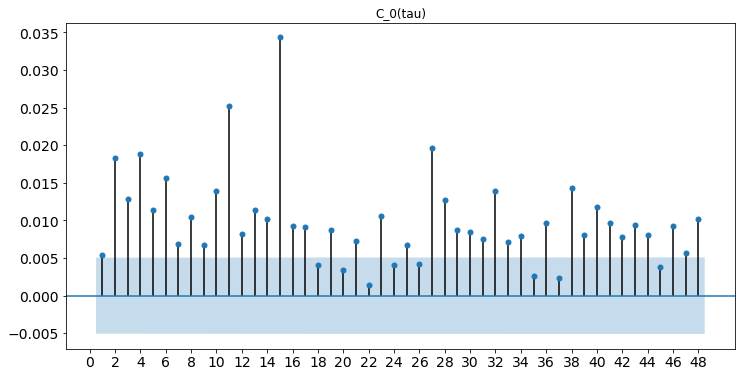

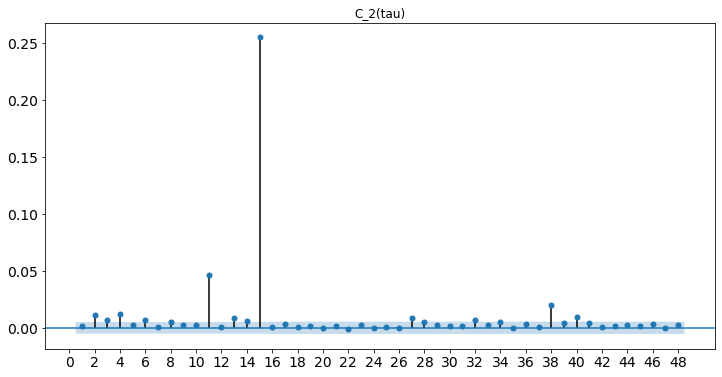

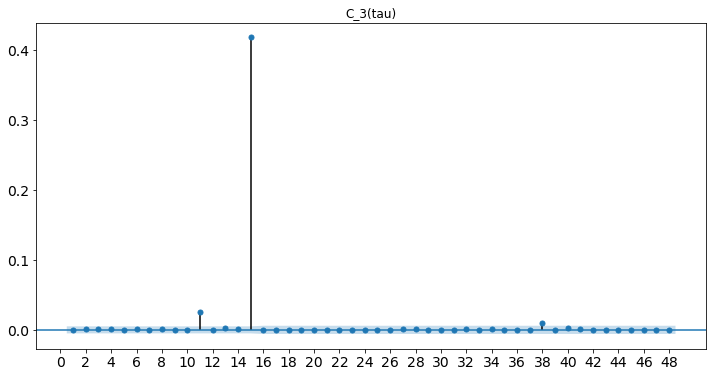

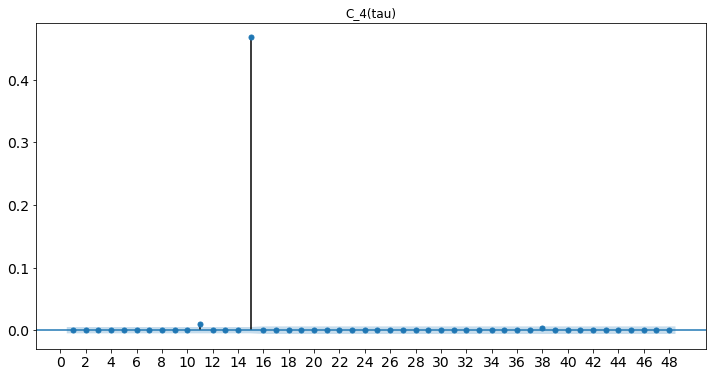

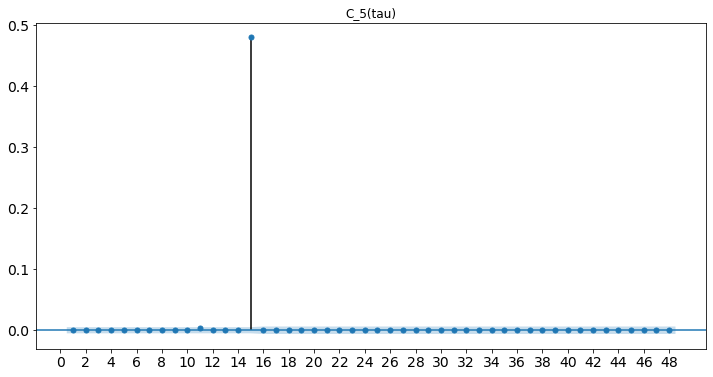

In [16]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(np.log(1+abs(data_ddpg['returns'].fillna(0))), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_0(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_ddpg['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_2(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_ddpg['returns'].fillna(0)**3), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_3(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_ddpg['returns'].fillna(0)**4), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_4(tau)')
plt.show()

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(abs(data_ddpg['returns'].fillna(0)**5), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('C_5(tau)')
plt.show()

Сумма квадров лагов автокорреляции должна сходиться к нормальной величине.

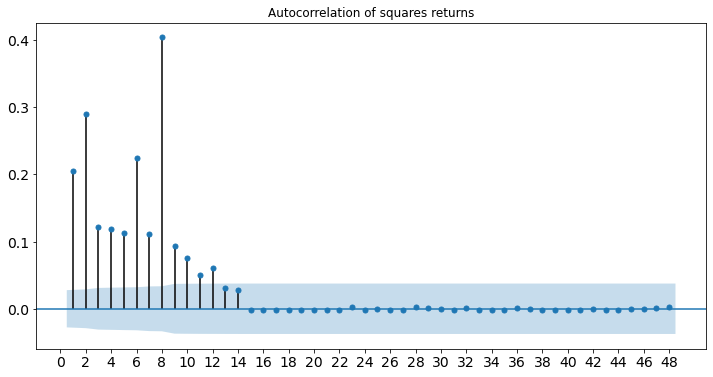

In [17]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_default['returns'][:5000].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of squares returns')
plt.show()

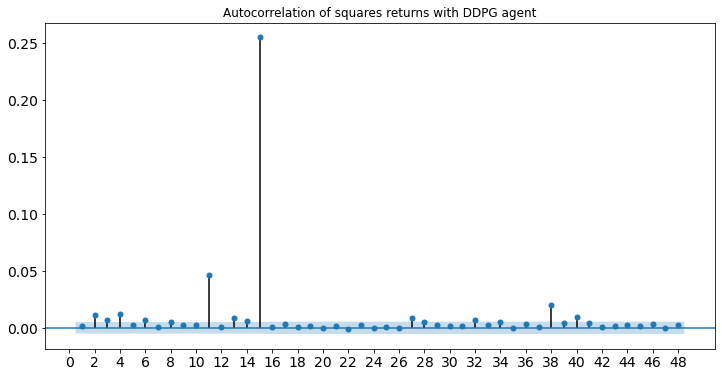

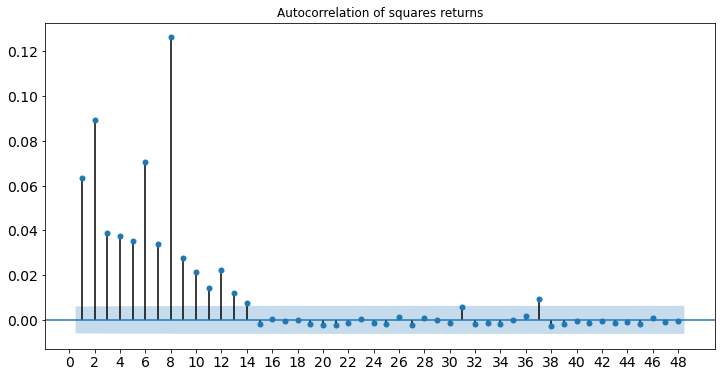

In [18]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_ddpg['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of squares returns with DDPG agent')
plt.show()
#print('Dickey—Fuller_test_value: p=%f' % adfuller(data_ddpg['returns'].fillna(0)**2)[1])

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_default['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of squares returns')
plt.show()
#print('Dickey—Fuller_test_value: p=%f' % adfuller(data_default['returns'].fillna(0)**2)[1])

-----
## Autocorrelation of returns

We'll observe simple linear cutocorrelation of returns and squared autocorrelation of returns.

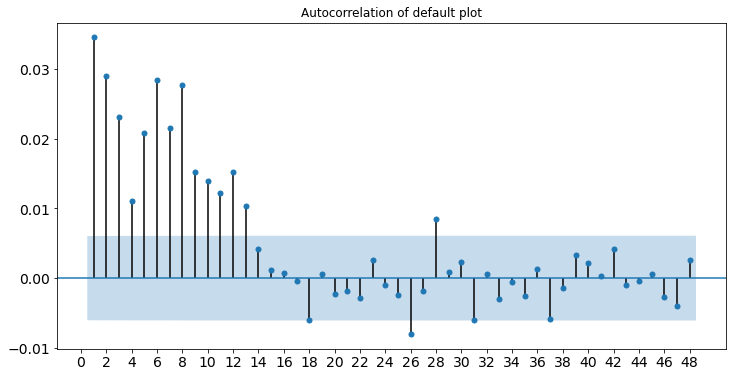

Dickey—Fuller_test_value: p=0.000000


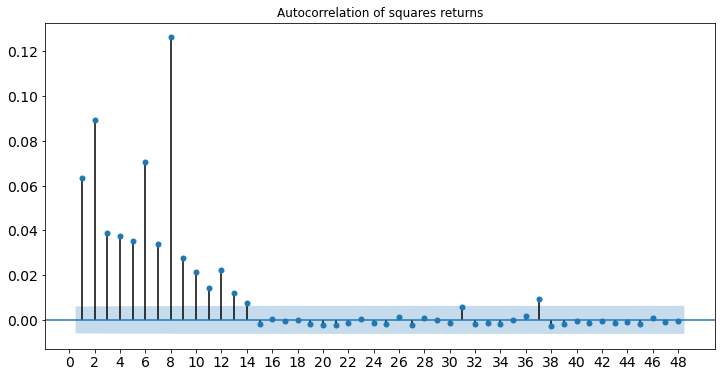

Dickey—Fuller_test_value: p=0.000000


In [19]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_default['returns'].fillna(0), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of default plot')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data_default['returns'].fillna(0))[1])

########

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_default['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of squares returns')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data_default['returns'].fillna(0)**2)[1])

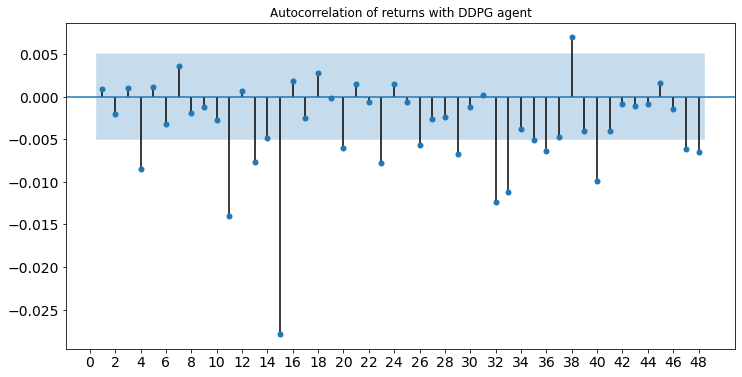

Dickey—Fuller_test_value: p=0.000000


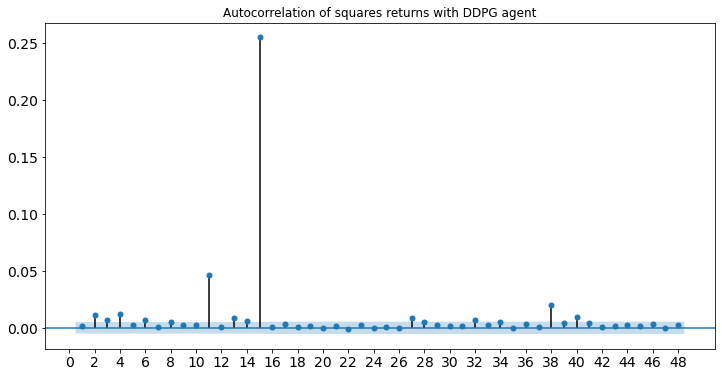

Dickey—Fuller_test_value: p=0.000000


In [20]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_ddpg['returns'].fillna(0), lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of returns with DDPG agent')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data_ddpg['returns'].fillna(0))[1])

########

plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_ddpg['returns'].fillna(0)**2, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.title('Autocorrelation of squares returns with DDPG agent')
plt.show()
print('Dickey—Fuller_test_value: p=%f' % adfuller(data_ddpg['returns'].fillna(0)**2)[1])

----
## Q-Q plot values  
Here we use Q-Q plot to observe comparisons of sampled quantiles obtained during the implementation of our process with the normal distribution (???)  (Normal or Gaussian, what will be better?)

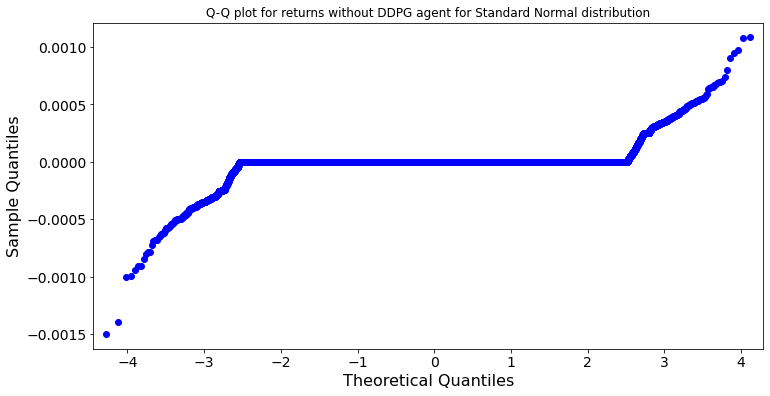

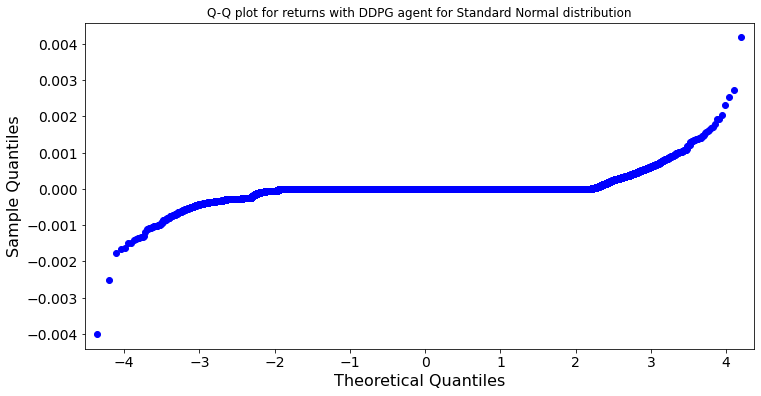

In [21]:
sm.qqplot(data_default['returns'])
plt.title('Q-Q plot for returns without DDPG agent for Standard Normal distribution')
plt.show()
sm.qqplot(data_ddpg['returns'])
plt.title('Q-Q plot for returns with DDPG agent for Standard Normal distribution')
plt.show()

------
### ECDF Plotting  

Let build empirical cumulative distribution function (ECDF) to compare 2 cumulative distributions

In [22]:
from statsmodels.distributions.empirical_distribution import ECDF

In [23]:
ecdf_default = ECDF(data_default['returns'].fillna(0))
ecdf_ddpg = ECDF(data_ddpg['returns'].fillna(0))

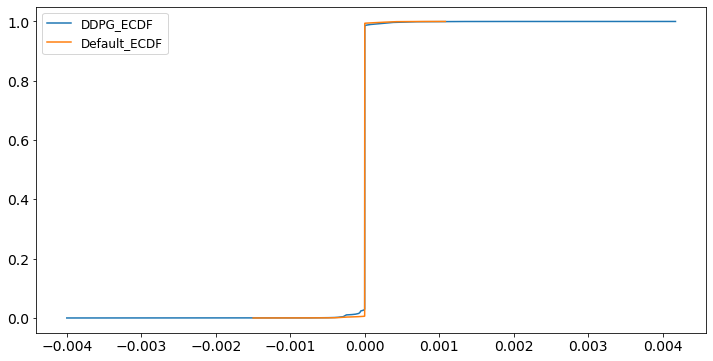

In [24]:
plt.plot(ecdf_ddpg.x, ecdf_ddpg.y, label = 'DDPG_ECDF')
plt.plot(ecdf_default.x, ecdf_default.y, label = 'Default_ECDF')
plt.legend()
plt.show()

Сделать. PDF plotting (можно сделать как гистограмму)

------
## Hill estimating  
for returns!

In [25]:
statistics_order = np.sort(data_default['returns'].fillna(0))

Do we want to use module values here?  
Что делать если у нас в порядковых статистиках нули? (я ко всему ряду прибавил 1)

In [26]:
hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data_default['returns'].fillna(0))))[:k]) - np.log(
    abs(np.sort(data_default['returns'].fillna(0))))[k]

hill_estimator_ddpg = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data_ddpg['returns'].fillna(0))))[:k]) - np.log(
    abs(np.sort(data_ddpg['returns'].fillna(0))))[k]

#Add one number

hill_estimator_default_one = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data_default['returns'].fillna(0))[::-1]+1))[:k]) - np.log(
    abs(np.sort(data_default['returns'].fillna(0))[::-1]+1))[k]

hill_estimator_ddpg_one = lambda k: 1/k*np.sum(np.log(abs(np.sort(
    data_ddpg['returns'].fillna(0))[::-1]+1))[:k]) - np.log(
    abs(np.sort(data_ddpg['returns'].fillna(0))[::-1]+1))[k]

In [27]:
len(data_default['returns'])

105016

<ipython-input-26-cc043d033838>:1: RuntimeWarning: divide by zero encountered in log
  hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(
<ipython-input-26-cc043d033838>:2: RuntimeWarning: divide by zero encountered in log
  data_default['returns'].fillna(0))))[:k]) - np.log(
<ipython-input-26-cc043d033838>:1: RuntimeWarning: invalid value encountered in double_scalars
  hill_estimator_default = lambda k: 1/k*np.sum(np.log(abs(np.sort(
<ipython-input-26-cc043d033838>:5: RuntimeWarning: divide by zero encountered in log
  hill_estimator_ddpg = lambda k: 1/k*np.sum(np.log(abs(np.sort(
<ipython-input-26-cc043d033838>:6: RuntimeWarning: divide by zero encountered in log
  data_ddpg['returns'].fillna(0))))[:k]) - np.log(
<ipython-input-26-cc043d033838>:5: RuntimeWarning: invalid value encountered in double_scalars
  hill_estimator_ddpg = lambda k: 1/k*np.sum(np.log(abs(np.sort(


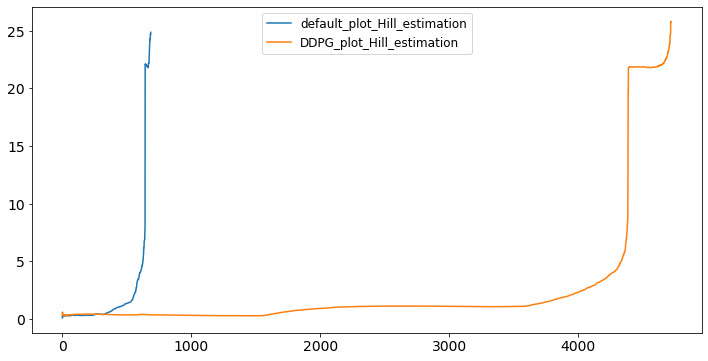

In [28]:
plt.plot([hill_estimator_default(t) for t in range(1, 10000)], label = 'default_plot_Hill_estimation')
plt.plot([hill_estimator_ddpg(t) for t in range(1, 10000)], label = 'DDPG_plot_Hill_estimation')
plt.legend()
plt.show()

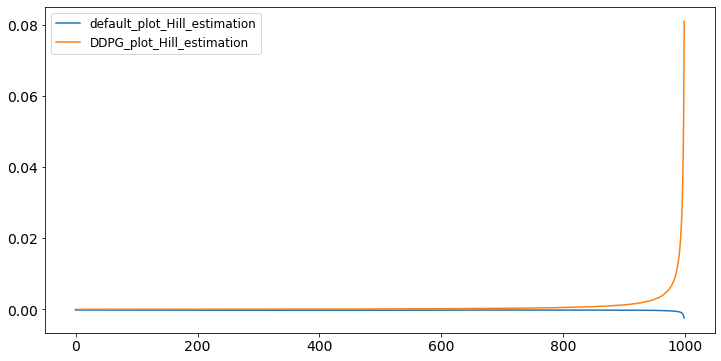

In [29]:
plt.plot([hill_estimator_default_one(t) for t in range(-1000, -1)], label = 'default_plot_Hill_estimation')
plt.plot([hill_estimator_ddpg_one(t) for t in range(-1000, -1)], label = 'DDPG_plot_Hill_estimation')
plt.legend()
plt.show()

In [30]:
ten_percent = np.array([hill_estimator_default_one(int(len(data_default['returns'])*0.1)), hill_estimator_ddpg_one(int(len(data_ddpg['returns'])*0.1))])
fifty_percent = np.array([hill_estimator_default_one(int(len(data_default['returns'])*0.5)), hill_estimator_ddpg_one(int(len(data_ddpg['returns'])*0.5))])
ninety_percent = np.array([hill_estimator_default_one(int(len(data_default['returns'])*0.9)), hill_estimator_ddpg_one(int(len(data_ddpg['returns'])*0.9))])

Добавить 1 и 5 процентов

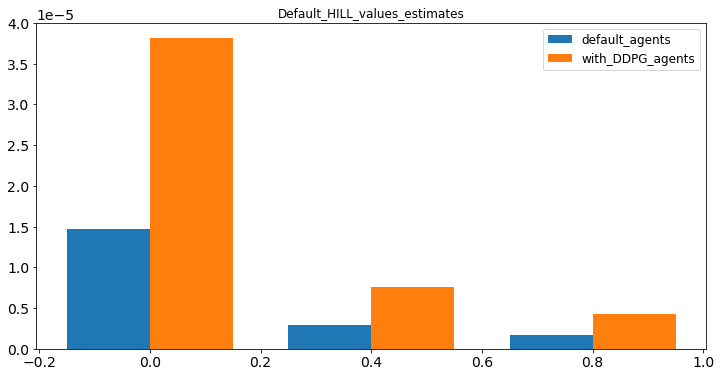

In [31]:
ax1 = np.transpose([ten_percent, fifty_percent, ninety_percent])[0]
ax2 = np.transpose([ten_percent, fifty_percent, ninety_percent])[1]
labels = [0.1, 0.5, 0.9]
x = np.arange(0, 1, 0.4)
width = 0.15

fig, ax = plt.subplots()
react1 = ax.bar(x-width/2, ax1, width, label = 'default_agents')
react2 = ax.bar(x+width/2, ax2, width, label = 'with_DDPG_agents')
#ax.set_xticklabels(labels)
ax.set_title("Default_HILL_values_estimates")
plt.legend()
plt.show()

LogLog ranksize regression

In [158]:
data_33 = data_default['returns'].fillna(0)
ln_data = np.log(data_default + 1).fillna(0)

data_33_ddpg = data_ddpg['returns'].fillna(0)
ln_data_ddpg = np.log(data_ddpg + 1).fillna(0)

<ipython-input-158-eb53762a71a5>:2: RuntimeWarning: invalid value encountered in log
  ln_data = np.log(data_default + 1).fillna(0)
<ipython-input-158-eb53762a71a5>:5: RuntimeWarning: invalid value encountered in log
  ln_data_ddpg = np.log(data_ddpg + 1).fillna(0)


In [159]:
ln_data_ddpg.shape

(150016, 14)

In [160]:
data_33.to_csv('123.csv')

In [161]:
data_33_ddpg.to_csv('ddpg_1.csv')

In [162]:
exp_reg = LinearRegression()
exp_reg.fit(ln_data, data_33)

exp_reg_ddpg = LinearRegression()
exp_reg_ddpg.fit(ln_data_ddpg, data_33_ddpg)

LinearRegression()

In [163]:
df_lr = pd.DataFrame({'rank':np.log10(range(1,data_33.shape[0]+1))[:-104200],
                      'degree':np.log10(sorted(data_33+1,reverse=True))[:-104200]})

df_lr_ddpg = pd.DataFrame({'rank':np.log10(range(1,data_33_ddpg.shape[0]+1))[:-147500],
                      'degree':np.log10(sorted(data_33_ddpg+1,reverse=True))[:-147500]})

In [168]:
X = df_lr[['rank']]
Y = df_lr[['degree']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

X_ddpg = df_lr_ddpg[['rank']]
Y_ddpg = df_lr_ddpg[['degree']]
X_ddpg = sm.add_constant(X_ddpg)
model_ddpg = sm.OLS(Y_ddpg, X_ddpg).fit()

In [169]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 degree   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.356e+04
Date:                Mon, 12 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:46:41   Log-Likelihood:                 7727.9
No. Observations:                 816   AIC:                        -1.545e+04
Df Residuals:                     814   BIC:                        -1.544e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   3.86e-06    136.071      0.000       0.001       0.001
rank          -0.0002   1.53e-06   -116.464      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       99.549   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.217
Skew:                           0.054   Prob(JB):                     1.23e-06
Kurtosis:                       2.112   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
model.params

const    0.000525
rank    -0.000178
dtype: float64

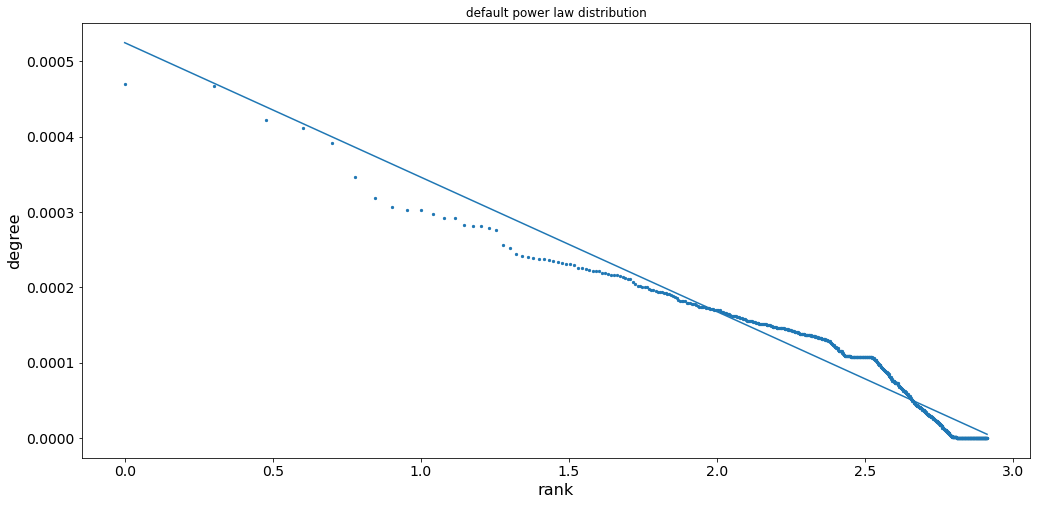

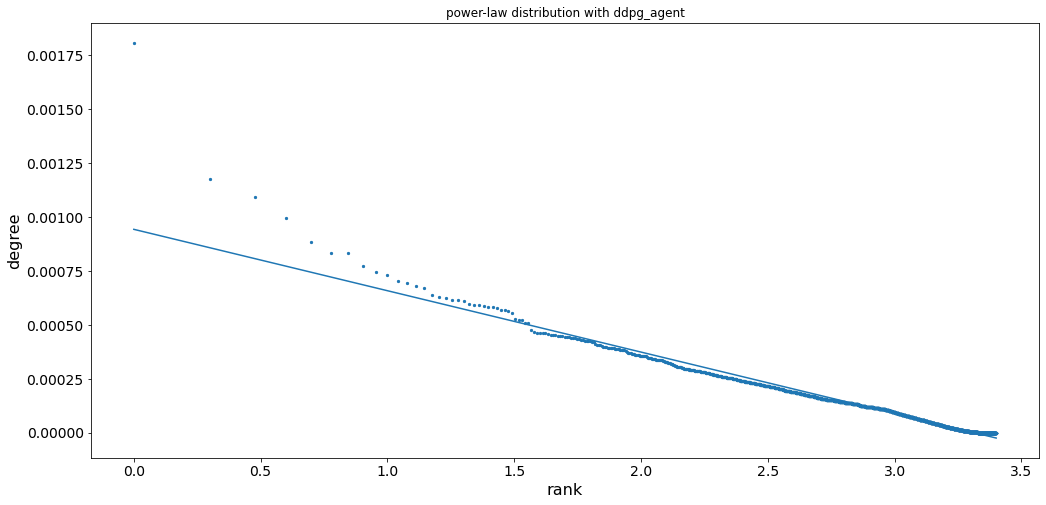

In [171]:
ax = df_lr.plot(x='rank', y='degree', kind='scatter',s=5)
plt.plot(df_lr['rank'], model.params['const'] + model.params['rank'] * df_lr['rank'])
plt.title('default power law distribution')

ax = df_lr_ddpg.plot(x='rank', y='degree', kind='scatter',s=5)
plt.plot(df_lr_ddpg['rank'], model_ddpg.params['const'] + model_ddpg.params['rank'] * df_lr_ddpg['rank'])
plt.title('power-law distribution with ddpg_agent')

plt.show()

In [144]:
model.params['rank']

-0.00017845599170445748

In [145]:
model_ddpg.params['rank']

-0.00028465657048897745

Произвести несколько симуляций, оценить хвосты распределений.  

Увеличение числа чартистов приводит к уменьшению тяжелохвостности.

curtosis for default row: 4.4.  
curtosis for ddpg row: 2.75.  



In [174]:
df_lr[['degree']].kurt()

degree    1.652768
dtype: float64

In [183]:
np.sort(df_lr[['degree']].values.reshape(-1))[::-1]

array([4.70273595e-04, 4.66488780e-04, 4.21440681e-04, 4.12005778e-04,
       3.92094823e-04, 3.46680837e-04, 3.19070555e-04, 3.06438735e-04,
       3.02750858e-04, 3.02674532e-04, 2.97434874e-04, 2.91995050e-04,
       2.91779700e-04, 2.82379245e-04, 2.81553967e-04, 2.81087748e-04,
       2.78776319e-04, 2.75899983e-04, 2.55846307e-04, 2.52677188e-04,
       2.44243841e-04, 2.42013777e-04, 2.40390485e-04, 2.38490615e-04,
       2.37576830e-04, 2.37253726e-04, 2.36426944e-04, 2.34271994e-04,
       2.33860752e-04, 2.31796268e-04, 2.30625496e-04, 2.30375100e-04,
       2.29475093e-04, 2.25669766e-04, 2.25474962e-04, 2.24087959e-04,
       2.22580980e-04, 2.21772077e-04, 2.21434389e-04, 2.21334322e-04,
       2.19143797e-04, 2.18419124e-04, 2.18077463e-04, 2.16999330e-04,
       2.16038464e-04, 2.15837073e-04, 2.15217004e-04, 2.13127437e-04,
       2.11753115e-04, 2.10985261e-04, 2.10919404e-04, 2.07279146e-04,
       2.04718378e-04, 2.02358543e-04, 2.01813405e-04, 2.00785444e-04,
      